In [4]:
#------------ Importing the libraries ------------#
import io
import os
import base64
import dash
import re
import math
import unicodedata
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import dash_core_components as dcc
import dash_html_components as html
import dash_bootstrap_components as dbc

from dash import callback_context
from datetime import datetime
from jupyter_dash import JupyterDash
from plotly.subplots import make_subplots
from dash.dependencies import Input, Output, State
from unicodedata import normalize
from dateutil.relativedelta import relativedelta

C:\Users\relat\AppData\Local\Temp\ipykernel_19896\741671748.py:73: FutureWarning: The default value of regex will change from True to False in a future version.
  data_agregada['MUNICIPIO_DE_RESIDENCIA']=data_agregada.MUNICIPIO_DE_RESIDENCIA.str.lower().str.strip().str.replace('[ ]+','_')


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1683 entries, 0 to 1682
Data columns (total 38 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   year                         1683 non-null   int64         
 1   MES                          1683 non-null   int64         
 2   NOMBRE_USUARIO               1683 non-null   object        
 3   cedula                       1683 non-null   object        
 4   Solicitud                    1683 non-null   int64         
 5   Autorizacion                 1683 non-null   int64         
 6   codigo                       1683 non-null   int64         
 7   DOCUMENTO_DE_IDENTIFICACION  1680 non-null   object        
 8   GENERO                       1680 non-null   object        
 9   FECHA_DE_NACIMIENTO          1680 non-null   datetime64[ns]
 10  LUGAR_DE_NACIMIENTO          1680 non-null   object        
 11  POBLACION_ESPECIAL           1680 non-null 

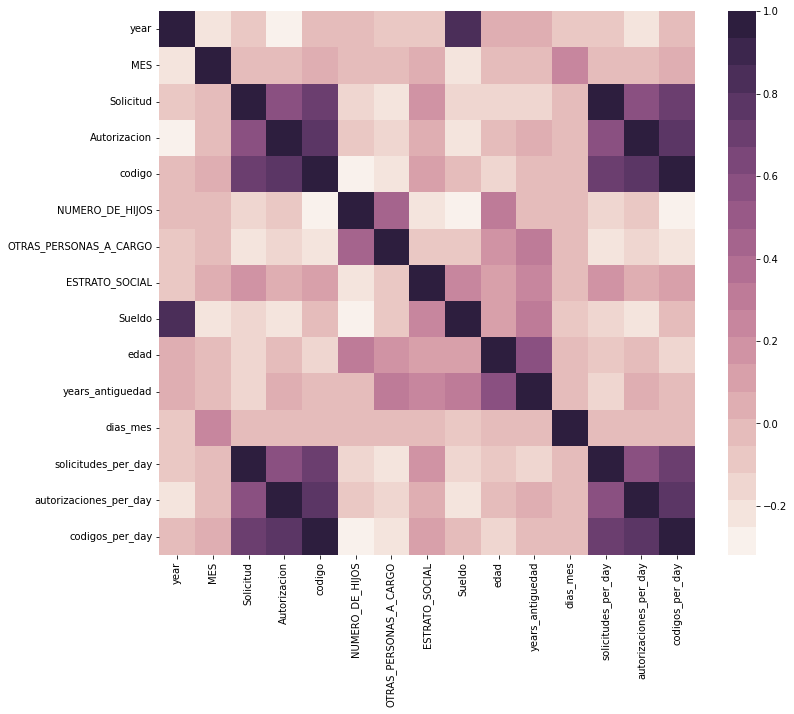

<AxesSubplot:xlabel='CENTRO_DE_TRABAJO', ylabel='solicitudes_per_day'>

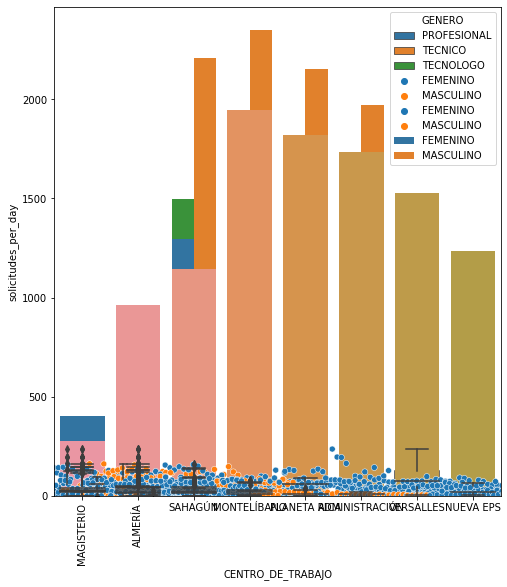

In [5]:
#ruta_madre="C:/Users/relat/Documents/GitHub/Team_224/Proyecto"
ruta_madre="C:/Users/relat/Documents/GitHub/Team_224/Proyecto"
ruta_insumos=os.path.join(ruta_madre, 'Insumos')
ruta_resultados=os.path.join(ruta_madre, 'Resultados')

##### importando ##########


### datos sueldos####
os.chdir(os.path.join(ruta_insumos,'Descripcion_empleados'))
sendero_sueldos=os.path.join(os.getcwd(),'Sueldos_nomina_consolidados.csv')
sueldos=pd.read_csv(sendero_sueldos,sep=";")
#sueldos['year']=sueldos['year'].astype('float64')
sueldos['Codigo']=sueldos['Codigo'].astype('int').astype('str')
sueldos.drop_duplicates(['year','Codigo','Nombres'],inplace=True)

## datos  demográficos ##########
os.chdir(os.path.join(ruta_insumos,"Encuesta_sociodem_empleados"))
sendero_feature=os.path.join(os.getcwd(),str(os.listdir()[0]))
feature_demo=pd.read_excel(sendero_feature)
#feature_demo.dropna(subset=["NOMBRE_CLAVE"],inplace=True)

#estadisticos_iniciales=consol_data.describe(include = ['O'])
## importando los datos de las actividades   #######

os.chdir(os.path.join(ruta_insumos,'Datos_eventos'))
sendero_eventos=os.path.join(os.getcwd(),str(os.listdir()[0]))
datos_eventos=pd.read_excel(sendero_eventos)
datos_eventos['cedula']=datos_eventos['cedula'].astype('str')
#datos_eventos.dropna(subset=["NOMBRE_CLAVE"],inplace=True)


'''descripcion variable. todo debe ser objeto porque ninguno se va a utilizar como float'''


##### limpieza de data#######

### creando variables utiles#####


feature_demo['NUMERO_DE_DOCUMENTO']=feature_demo.NUMERO_DE_DOCUMENTO.astype('int').astype('str').str.strip()
sueldos['Codigo']=sueldos['Codigo'].str.strip()


consol_data_con_features=datos_eventos.merge(feature_demo,how='left',right_on='NUMERO_DE_DOCUMENTO',left_on='cedula')

data_agregada=consol_data_con_features.merge(sueldos[['year','Codigo','Sueldo','Cargo']],how='left',left_on=['year','cedula'],right_on=['year','Codigo'])

## crear edad

##data_agregada['Wage_fixed']=np.where(data_agregada.Sueldo.isna(),data_agregada.SALARIO , data_agregada.Sueldo)

data_agregada['fecha_analisis']=[pd.to_datetime(datetime(data_agregada['year'][x],data_agregada['MES'][x],1)) for x in range(len(data_agregada['year']))]

years_born=data_agregada['fecha_analisis']-data_agregada['FECHA_DE_NACIMIENTO']

data_agregada['edad']=years_born.dt.days//360; del years_born
 
## crear años de experiencia#####

expertise=data_agregada['fecha_analisis']-data_agregada['FECHA_DE_INGRESO']
data_agregada['years_antiguedad']=expertise.dt.days/360 ; del expertise

data_agregada.drop(columns=['NOMBRES','APELLIDOS','Codigo','NUMERO_DE_DOCUMENTO'],inplace=True)

## arreglar genero( esta bien)

### arreglar poblacion especial


###arreglar municipio

data_agregada['MUNICIPIO_DE_RESIDENCIA']=data_agregada.MUNICIPIO_DE_RESIDENCIA.str.lower().str.strip().str.replace('[ ]+','_')

def normalizar(x):
    
    caracter_norm=re.sub(
        r"([^n\u0300-\u036f]|n(?!\u0303(?![\u0300-\u036f])))[\u0300-\u036f]+", r"\1", 
            normalize( "NFD", x
            ), 0, re.I
        )
    return caracter_norm

prueba=[]
for i in range(len(data_agregada['MUNICIPIO_DE_RESIDENCIA'])):
    
    try:
        prueba.append(normalizar(data_agregada['MUNICIPIO_DE_RESIDENCIA'][i]))
    except:
        
        prueba.append(np.nan)
    
    
data_agregada['MUNICIPIO_DE_RESIDENCIA']=prueba ## se le quita las tildes

### normalizar las solicitudes###

## que quede solicitudes, autorizaciones por dia para evitar el sesgo por mayores dias en un mes

data_agregada['fecha_fin']=pd.to_datetime([data_agregada['fecha_analisis'][j]+relativedelta(months=1) for j in range(len(data_agregada['fecha_analisis']))])
data_agregada['dias_mes']=data_agregada['fecha_fin']-data_agregada['fecha_analisis']
data_agregada['dias_mes']=data_agregada['dias_mes'].dt.days
data_agregada['solicitudes_per_day']=data_agregada['Solicitud']/data_agregada['dias_mes']
data_agregada['autorizaciones_per_day']=data_agregada['Autorizacion']/data_agregada['dias_mes']
data_agregada['codigos_per_day']=data_agregada['codigo']/data_agregada['dias_mes']


###profesion##

data_agregada['PROFESION']=data_agregada['PROFESION'].str.lower()

prueba=[]
for i in range(len(data_agregada['PROFESION'])):
    
    try:
        prueba.append(normalizar(data_agregada['PROFESION'][i]))
    except:
        
        prueba.append(np.nan)
   
    
data_agregada['PROFESION']=prueba

profesiones={'administracion de empresas':'admin_empresas',
             'administrador en servicios de la salud':'admin_servicios_salud',
             'secretaria':'secretariado',
             'asistente administrativo':'asistente_administrativo',
             'tecnico en auxiliar de enfermeria':'auxiliar_enfermeria',
             'auxiliar de enfermeria':'auxiliar_enfermeria',
             'tecnico auxiliar de enfermera':'auxiliar_enfermeria',
             'tecnico auxiliar de enfemeria':'auxiliar_enfermeria',
             'tecnico en agente  call center':'agente_call_center',
             'tecnico agente de contact center':'agente_call_center',
             'administrador en salud':'admin_servicios_salud',
             'administracion en salud':'admin_servicios_salud',
             'administrador de empresas':'admin_empresas',
             'tecnico en asistencia administrativa':'asistente_administrativo'
             }

data_agregada['PROFESION']=data_agregada['PROFESION'].replace(profesiones)

#### arreglando NIVEL ESCOLARIDAD###############

prueba=[]
for i in range(len(data_agregada['NIVEL_DE_ESCOLARIDAD'])):
    
    try:
        prueba.append(normalizar(data_agregada['NIVEL_DE_ESCOLARIDAD'][i]))
    except:
        
        prueba.append(np.nan)
   
  
data_agregada['NIVEL_DE_ESCOLARIDAD']=prueba


###### Exploratoy Data Analysis#######

## info general
data_agregada.info() ## la variables provenientes de los sueldos año a año, tienen cerca del 56% de la data dañada por falta de info de sueldos en ciertos años, 

## describe las variables numericas y categoricas
data_agg_describe_numeric=data_agregada.describe()
data_agg_describe_object=data_agregada.describe(include=['O'])


# 
# ax=sns.heatmap(corr_data, annot=True, cmap=sns.cubehelix_palette(20,  light=0.95, dark=0.15))
# ax.xaxis.tick_top
# plt.show()
#### grafica de correlacion
plt.figure(figsize=(12,10))
corr = data_agregada.corr()
ax=sns.heatmap(corr, annot=False, cmap=sns.cubehelix_palette(20,  light=0.95, dark=0.15))
ax.xaxis.tick_top
plt.show()


## graficas de visualizacion

plt.figure(figsize=(8,9))

## solicitud atendidas por year
sns.lineplot(x='year',y='Solicitud',data=data_agregada)

## solicitudes per capita atendias por year
suma_solicitudes=data_agregada.groupby('year').agg({'Solicitud': 'sum', 'NOMBRE_USUARIO': 'count'}).reset_index()
suma_solicitudes['prod_per_capita']=suma_solicitudes.Solicitud/suma_solicitudes.NOMBRE_USUARIO
sns.barplot(x='year',y='prod_per_capita',data=suma_solicitudes)


#######################################################################

## solicitudes per capita atendias por genero
suma_solicitudes_Genero =data_agregada.groupby(['year','GENERO']).agg({'Solicitud': 'sum', 'NOMBRE_USUARIO': 'count'}).reset_index()
suma_solicitudes_Genero['prod_per_capita']=suma_solicitudes_Genero.Solicitud/suma_solicitudes_Genero.NOMBRE_USUARIO
sns.barplot(x='year',y='prod_per_capita',hue='GENERO',data=suma_solicitudes_Genero)

#######################################################################

sns.boxplot(x='GENERO',y='solicitudes_per_day',hue='NIVEL_DE_ESCOLARIDAD',data=data_agregada)
sns.boxplot(x='GENERO',y='solicitudes_per_day',data=data_agregada)
data_agregada.groupby('GENERO')['NIVEL_DE_ESCOLARIDAD'].value_counts()
#######################################################################

## solicitudes per capita atendias por edad
suma_solicitudes_Edad =data_agregada.groupby(['edad']).agg({'Solicitud': 'sum', 'NOMBRE_USUARIO': 'count'}).reset_index()
suma_solicitudes_Edad['prod_per_capita']=suma_solicitudes_Edad.Solicitud/suma_solicitudes_Edad.NOMBRE_USUARIO
plt.xticks(rotation=90)
sns.barplot(x='edad',y='prod_per_capita',data=suma_solicitudes_Edad)

#######################################################################

# Parece no haber una relacion importante entre años de experiencia, edad y solicitudes por dia
sns.scatterplot(x='years_antiguedad',y='solicitudes_per_day',hue='GENERO',data=data_agregada)
#plt.title('años de antiguedad vs solicitudes por dia')
sns.scatterplot(x='edad',y='solicitudes_per_day',hue='GENERO',data=data_agregada)

#######################################################################

sns.boxplot(x='ESTADO_CIVIL',y='solicitudes_per_day',data=data_agregada)
#plt.title('años de antiguedad vs solicitudes por dia')
sns.boxplot(x='ESTRATO_SOCIAL',y='solicitudes_per_day',data=data_agregada)
sns.boxplot(x='OTRAS_PERSONAS_A_CARGO',y='solicitudes_per_day',data=data_agregada)
sns.boxplot(x='TIPO_DE_VIVIENDA',y='solicitudes_per_day',data=data_agregada)
sns.boxplot(x='CENTRO_DE_TRABAJO',y='solicitudes_per_day',data=data_agregada)
#######################################################################


In [57]:
suma_solicitudes.rename(columns={'Solicitud':'request', 
                                   'NOMBRE_USUARIO':'Num_of_employees',
                                   'prod_per_capita':'request/Num_of_employees'}, inplace = True)
fig1 = px.box(suma_solicitudes, x="year", y="request/Num_of_employees", points="all")
fig1.show()

In [60]:
suma_solicitudes_Genero.rename(columns={'Solicitud':'request', 
                                       'NOMBRE_USUARIO':'Num_of_employees',
                                        'GENERO':'genero',
                                       'prod_per_capita':'request/Num_of_employees'}, inplace = True)
fig2 = px.scatter(suma_solicitudes_Genero, x="year", y="request/Num_of_employees", facet_col="genero")
fig2.show()

In [69]:
data_agregada

,year,MES,NOMBRE_USUARIO,cedula,Solicitud,Autorizacion,codigo,DOCUMENTO_DE_IDENTIFICACION,GENERO,FECHA_DE_NACIMIENTO,...,Sueldo,Cargo,fecha_analisis,edad,years_antiguedad,fecha_fin,dias_mes,solicitudes_per_day,autorizaciones_per_day,codigos_per_day
0,2014,6,ROSY MUÑOZ,30574770,228,224,62,CÉDULA DE CIUDADANÍA,FEMENINO,1975-10-19,...,NaN,NaN,2014-06-01,39.0,7.691667,2014-07-01,30,7.600000,7.466667,2.066667
1,2014,6,VILMA PADILLA,39144315,108,106,58,CÉDULA DE CIUDADANÍA,FEMENINO,1983-11-03,...,NaN,NaN,2014-06-01,31.0,2.577778,2014-07-01,30,3.600000,3.533333,1.933333
2,2014,7,ROSY MUÑOZ,30574770,414,415,85,CÉDULA DE CIUDADANÍA,FEMENINO,1975-10-19,...,NaN,NaN,2014-07-01,39.0,7.775000,2014-08-01,31,13.354839,13.387097,2.741935
3,2014,7,VILMA PADILLA,39144315,108,98,70,CÉDULA DE CIUDADANÍA,FEMENINO,1983-11-03,...,NaN,NaN,2014-07-01,31.0,2.661111,2014-08-01,31,3.483871,3.161290,2.258065
4,2014,8,ROSY MUÑOZ,30574770,338,339,64,CÉDULA DE CIUDADANÍA,FEMENINO,1975-10-19,...,NaN,NaN,2014-08-01,39.0,7.861111,2014-09-01,31,10.903226,10.935484,2.064516
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1678,2022,4,YEIMI JOHANA BARRERA VARILLA,1067941858,375,125,189,CÉDULA DE CIUDADANÍA,FEMENINO,1995-06-16,...,1060000.0,GESTOR DE SALUD,2022-04-01,27.0,1.080556,2022-05-01,30,12.500000,4.166667,6.300000
1679,2022,4,YERALDIN YAMITH LOBO VILLEGAS,1067921481,4918,1,6,CÉDULA DE CIUDADANÍA,FEMENINO,1993-02-25,...,1060000.0,GESTOR DE SALUD,2022-04-01,29.0,4.730556,2022-05-01,30,163.933333,0.033333,0.200000
1680,2022,4,YESSIKA PAOLA GONZALEZ RAMOS,1069479384,248,1,136,CÉDULA DE CIUDADANÍA,FEMENINO,1989-08-02,...,NaN,NaN,2022-04-01,33.0,10.394444,2022-05-01,30,8.266667,0.033333,4.533333
1681,2022,4,YULIETH PAOLA DURANGO COGOLLO,1003713362,923,17,147,CÉDULA DE CIUDADANÍA,FEMENINO,2000-12-30,...,NaN,NaN,2022-04-01,21.0,2.958333,2022-05-01,30,30.766667,0.566667,4.900000


In [75]:
data_agregada.Cargo.unique()

array([nan, 'AUXILIAR CITAS ', 'GESTOR DE SALUD ',
       'PROFESIONAL DE CITAS MEDICAS  '], dtype=object)

## Dash & Boostrap Layout

In [99]:
link_logo = 'https://covid19medicinaintegral.com/wp-content/uploads/2019/12/logo_Mesa-de-trabajo-1-300x154.png'

app = JupyterDash(__name__, external_stylesheets = [dbc.themes.BOOTSTRAP], meta_tags=[{'content': 'width=device-width'}])

###------------ Layout section: Boostrap ------------###

app.layout = dbc.Container(
    #style = {'background-image': 'url("https://w0.peakpx.com/wallpaper/993/494/HD-wallpaper-coffee-beans-coffee-green-leaves-coffee-concepts-grains.jpg")',
    #        'background-repeat': 'no-repeat', 'background-position': 'center', 'background-size': '2880px 1800px'},
    children = [

    dbc.Navbar(
         html.A(
            dbc.Row(
                [
                    dbc.Col(html.Div(), className = 'ms-5'),
                    #dbc.Col(dbc.NavbarBrand(html.H2('Análisis de Data', style = {'font-family': 'Verdana', 'font-weight': 'bold'}), 
                    #className = 'ms-4 float-end')),
                    dbc.Col(html.Img(src = link_logo, height = '120px')),

                ],
                justify = 'end', 
                align = 'left', 
                className = 'g-0',            

                ),
                href = 'https://covid19medicinaintegral.com/', 
                style = {'textDecoration': 'none'},

        ),
        color = '#81DAF5', 
    ),

###------------ Layout: Página Principal ------------### 
#------------ Upload files option ------------#
    
# dbc.Row([
    
#     dcc.Upload(
#                     id='upload-data',
#                     children=html.Div([
#                         'Drag and Drop or ',
#                         html.A('Select Files')
#                     ]),
#                     style={
#                         'width': '446%',
#                         'height': '60px',
#                         'lineHeight': '60px',
#                         'borderWidth': '1px',
#                         'borderStyle': 'dashed',
#                         'borderRadius': '5px',
#                         'textAlign': 'center',
#                         'margin': '10px'
#                     },
#                     # Allow multiple files to be uploaded
#                     multiple=False
#     ),
# ]),

#------------ CARDs con indicadores relevantes  ------------# 

    dbc.Row([

        dbc.Col([
            dbc.Card([
                dbc.CardBody(
                [
                    html.H4("35 ", style = {'textAlign': 'center'}, className="card-title"),
                    dbc.CardFooter("Numero de empleados", style = {'font-family': 'Verdana','font-size': 16, 'textAlign': 'center'}),
                ]
            ),
            
            ], className="mb-3",),
        ], width = 3, className = 'mt-4 ms-5'),

        dbc.Col([
            dbc.Card([
                dbc.CardBody(
                [
                    html.H4("16", style = {'textAlign': 'center'}, className="card-title"),
                    dbc.CardFooter("Número de hombres", style = {'font-family': 'Verdana','font-size': 16, 'textAlign': 'center'}),
                ]
            ),
            
            ], className="mb-3",),
        ], width = 3, className = 'mt-4'),

        dbc.Col([
            dbc.Card([
                dbc.CardBody(
                [
                    html.H4("19", style = {'textAlign': 'center'}, className="card-title"),
                    dbc.CardFooter("Numero de mujeres", style = {'font-family': 'Verdana','font-size': 16, 'textAlign': 'center'}),
                ]
            ),
            
            ], className="mb-3",)
        ], width = 2, className = 'mt-4'),

    dbc.Col([
        dbc.Card([
            dbc.CardBody(
                [
                    html.H4("700", style = {'textAlign': 'center'}, className="card-title"),
                    dbc.CardFooter("Rendimiento por empleado promedio", style = {'font-family': 'Verdana','font-size': 16, 'textAlign': 'center'}),
                ]
            ),
            
            ], className="mb-3",),
        ], width =2, className = 'mt-4'),

    dbc.Col([

        dcc.Upload(children = html.Div([dbc.Button('Subir otro archivo', outline = False, color = 'primary', size = 'lg', className = 'mt-5 me-1'),])),

    ], className = 'ms-4'),

    ], className = "gx-5"),

    html.Hr(),

###------------ Fila 2: Gráfico de eficiencia ------------###    

dbc.Row([

    dbc.Col([dcc.Graph(id = 'distribution1-plot', figure = fig1)], width = 4, className = 'ms-5'),
    dbc.Col([dcc.Graph(id = 'distribution2-plot', figure = fig2)], width = 4),
    dbc.Col([

        dbc.Row([
            html.P('Edad', style = {'font-family': 'Verdana', 'font-weight': 'bold'}, className = 'ms-3'),
            dcc.Slider(18, 64, marks = None, value = 25, id = 'presion-slider'),
        ], className = 'mt-4'),
        
        dbc.Row([
            html.P('Estado Civil', style = {'font-family': 'Verdana', 'font-weight': 'bold'}, className = 'ms-3'),
            #dcc.Slider(0, 100, marks = None, value = 60, id = 'temperature-slider'),
            #caracteristicas = ('cas0/a','soltero/a','union libre')
            dcc.Dropdown(['cas0/a','soltero/a','union libre'], 'soltero/a', id='temperature-slider')
            
        ], className = 'mt-4'),

        dbc.Row([
            html.P('Rendimiento', style = {'font-family': 'Verdana', 'font-weight': 'bold'}, className = 'ms-3'),
            dcc.Slider(0, 3000, marks = None, value = 1500, id = 'flujo-slider'),
        ], className = 'mt-4'),

    ], width = 3, className = 'mt-4 ms-5 border rounded'),

], className = 'mt-5'),

###------------ Fila 3: Box Plot de Eficiencia a través de los meses ------------### 

dbc.Row([

    dbc.Col([dcc.Graph(id = 'efficiency2-plot', figure = fig1)], width = 4, className = 'ms-5'),
    dbc.Col([dcc.Graph(id = 'box-plot', figure = fig2)], width = 4),
    dbc.Col([

        dbc.Row([
            dbc.Card([
                dbc.CardBody(
                    [
                    dbc.CardHeader("Rangos de edades", style = {'font-family': 'Verdana', 'font-weight': 'bold', 'font-size': 18, 'textAlign': 'center'}),
                    html.H4("22 - 45 años", style = {'font-family': 'Verdana', 'textAlign': 'center'}, className="card-text"),
                    ]
                ),
            
            ], className="mb-3",),
        ]),
        
        dbc.Row([
            
            dbc.Card([
                dbc.CardBody(
                    [
                    dbc.CardHeader("Rangos de rendimiento", style = {'font-family': 'Verdana', 'font-weight': 'bold', 'font-size': 18, 'textAlign': 'center'}),
                    html.H4("700 - 900 solicitud/dia", style = {'font-family': 'Verdana', 'textAlign': 'center'}, className="card-text"),
                    ]
                ),
            
            ], className="mb-3",),

        ]),

        dbc.Row([
            
            dbc.Card([
                dbc.CardBody(
                    [
                    dbc.CardHeader("Estrato socio economico", style = {'font-family': 'Verdana', 'font-weight': 'bold', 'font-size': 18, 'textAlign': 'center'}),
                    html.H4("2 - 4", style = {'font-family': 'Verdana', 'textAlign': 'center'}, className="card-text"),
                    ]
                ),
            
            ], className="mb-3",),

        ]),

    ], width = 3, className = 'mt-5 ms-5 border rounded'),

]),

], fluid = True) 


#------------ Display ------------#

if __name__ == '__main__':
    app.run_server(debug = True, use_reloader = False, port = 8053)

Dash app running on http://127.0.0.1:8053/
